In [5]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
#from tabulate import tabulate

In [6]:
#Web Scraping - https://pythonprogramminglanguage.com/web-scraping-with-pandas-and-beautifulsoup/
res = requests.get("http://www.fedearroz.com.co/new/precios.php")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
#print( tabulate(df[0], headers='keys', tablefmt='psql') )

In [7]:
#Data Wrangling
arroz=df[0]
arroz.columns = arroz.iloc[0]
arroz = arroz.set_index(['Mes'])
arroz = arroz.drop(['Mes'])
arroz = arroz.rename(index={'Enero': '1', 
                            'Febrero': '2', 
                            'Marzo': '3', 
                            'Abril': '4', 
                            'Mayo': '5',
                            'Junio': '6',
                            'Julio': '7',
                            'Agosto': '8',
                            'Septiembre': '9',
                            'Octubre': '10',
                            'Noviembre': '11',
                            'Diciembre': '12'})
arroz = arroz.reset_index()
arroz = pd.melt(arroz, id_vars=['Mes'],var_name='Year',value_name='Price')
arroz = arroz.rename(columns={'Mes': 'Month'})
arroz['Year'] = arroz['Year'].astype(int)
arroz['Month'] = arroz['Month'].astype(int)
arroz = arroz.dropna()

#pd.to_datetime((df.Y*10000+df.M*100+df.D).apply(str),format='%Y%m%d')
arroz['Date']=pd.to_datetime((arroz.Year*10000+arroz.Month*100+1).apply(str),format='%Y%m%d')

arroz=arroz[['Date','Price']]
arroz['Price']=arroz['Price']/1000

arroz = arroz.set_index('Date')

In [8]:
arroz.head(12)

,Price
Date,
2010-01-01,817.456
2010-02-01,884.395
2010-03-01,796.473
2010-04-01,787.395
2010-05-01,803.395
2010-06-01,853.903
2010-07-01,797.759
2010-08-01,816.705
2010-09-01,848.036


In [9]:
arroz.tail(8)

,Price
Date,
2018-01-01,875.371
2018-02-01,895.089
2018-03-01,910.929
2018-04-01,919.643
2018-05-01,944.357
2018-06-01,950.000
2018-07-01,936.536
2018-08-01,925.381


/home/drivera/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

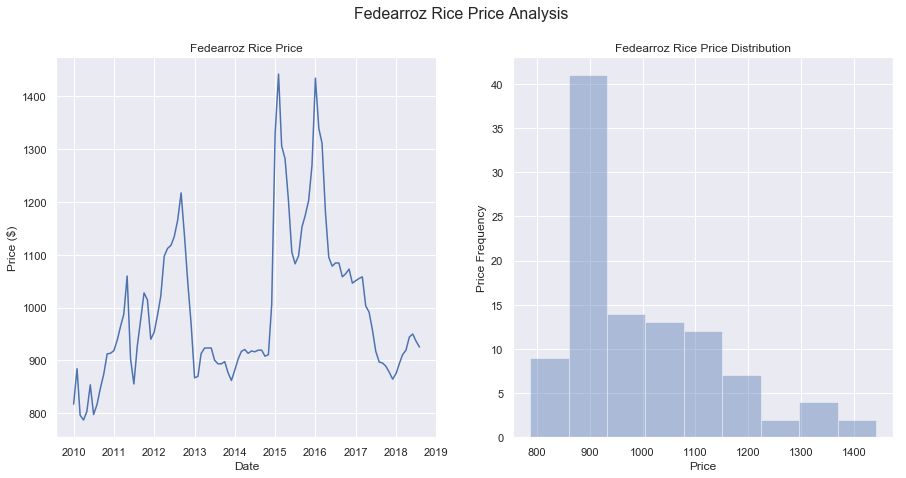

In [10]:
#Timeseries and Distribuition Plot

fig = plt.figure()
sns.set()

f, axs = plt.subplots(2,2,figsize=(15,7))

plt.subplot(121)
sns.lineplot(x=arroz.index, 
             y="Price", 
             data=arroz)
plt.title('Fedearroz Rice Price')
plt.ylabel('Price ($)')

plt.subplot(122)
sns.distplot(arroz.Price,
                    kde=False,
                    color="b")
plt.title('Fedearroz Rice Price Distribution')
plt.ylabel('Price Frequency')

plt.suptitle('Fedearroz Rice Price Analysis', fontsize=16)
plt.show()


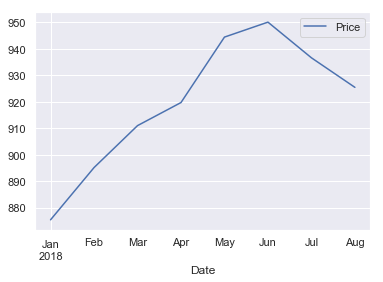

In [11]:
arroz2018 = arroz['2018']
arroz2018.plot()

In [12]:
quarterly = arroz['Price'].resample('Q')
quarterly_mean = quarterly.mean()

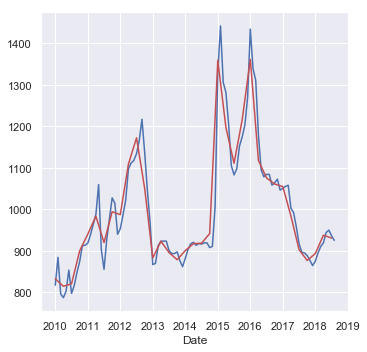

In [13]:
fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.add_subplot(1,1,1)

arroz['Price'].plot(ax=ax, color='b')
quarterly_mean.plot(ax=ax, color='r')

In [14]:
import fbprophet

In [15]:
# Prophet requires columns ds (Date) and y (value)
arroz_pred = arroz.reset_index()
arroz_pred = arroz_pred.rename(columns={'Date': 'ds', 'Price': 'y'})

# Make the prophet model and fit on the data
arroz_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
arroz_prophet.fit(arroz_pred)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/drivera/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
# Make a future dataframe for 2 years
arroz_forecast = arroz_prophet.make_future_dataframe(periods=12 * 1, freq='M')

# Make predictions
arroz_forecast = arroz_prophet.predict(arroz_forecast)

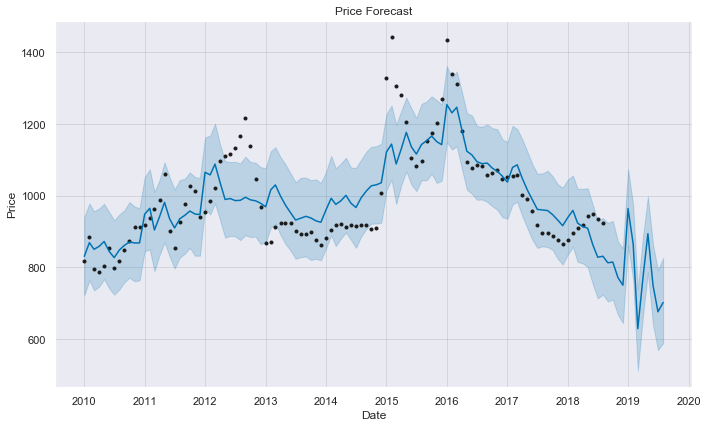

In [19]:
arroz_prophet.plot(arroz_forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Price Forecast')
plt.savefig('Price Forecas.png')

The black dots represent the actual values (notice how they stop at  2018), the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty (always a critical part of any prediction). The region of uncertainty increases the further out in the future the prediction is made because initial uncertainty propagates and grows over time.


According to this analysis it is expected that for the last months of this year the price will begin to fall, and rise drastically at the beginning of next year